## 2.0 Capstone Project Two: All State Purchase Prediction - Exploratory Data Analysis <a id='2_Exploratory_Data_Analysis'></a>
**Submitted By:** Amit Kukreja

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 All State Purchase Prediction - Exploratory Data Analysis](#2_Exploratory_Data_Analysis)

  * [2.1 Contents](#2.1_Contents)

  * [2.2 EDA Objectives](#2.2_EDA_Objectives)

  * [2.3 A Quick Look at Test Data](#2.3_Test_Data)

  * [2.4 Dealing with Categorical & Day/Time Variables](#2.3_Categorical_Variables)
      * [2.4.1 State](#2.4.1_State)
      * [2.4.2 Location](#2.4.2_Location)
      * [2.4.3 Day](#2.4.3_Day)
      * [2.4.4 Time](#2.4.4_Time)
      * [2.4.5 Car Value](#2.4.5_Car_Value)
      * [2.4.6 Risk Factor](#2.4.6_Risk_Factor)
      * [2.4.7 C_Previous](#2.4.7_C_Previous)
      * [2.4.8 Group_Size](#2.4.8_Group_Size)
      * [2.4.9 Categorical variables - conclusion](#2.4.9_Categorical_variables_conclusion)          
  
  * [2.5 Numerical Variables](#2.5_Numerical_Variables)
      * [2.5.1 shopping_pt](#2.5.1_shopping_pt)
      * [2.5.2 Other numerical variables](#2.5.2_Other_numerical_variables)
      * [2.5.3 Numerical variables conclusion](#2.5.3_Numerical_variables_conclusion)
      
  * [2.6 Boolean Variables](#2.6_Boolean_Variables)
      * [2.6.1 record_type](#2.6.1_record_type)
      * [2.6.2 homeowner and married_couple](#2.6.2_homeowner_and_married_couple)
      * [2.6.3 Boolean variables - conclusion](#2.6.3_Boolean_variables_conclusion)
      
  * [2.7 Dealing with Shopping History](#2.7_Shopping_History)

  * [2.8 Summary](#2.8_Summary)
  

## 2.2 EDA Objectives<a id='2.2_EDA_Objectives'></a>

* Visualizations
        * Number of changes per code (box plot) 
        * For people with more than 10 codes
            * Cramers V correlation between each code and the final code box plot https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
            * Or could just do # of codes in common 
        * For both of these could break it down by each code (% shared same code) 
* If time: write up draft EDA report in google doc 
        * Choose 3-10 charts from your analysis to put in a google doc as, and write brief explanation of why they are meaningful. Share with me and give me edit access at bsbell21@gmail.com
        * make sure to include titles and axis titles (with units) for each chart
        * you’ll probably want to lead with the univariate chart of the target, general rule is go high level to specific
                * univariate
                * Bivariate charts
                * Correlation matrix
                * Feature importances
        * Along with the explanation, you can also add in your statistical testing here but it will be brief  


In [2]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sb_utils import save_file
from collections import defaultdict
from collections import Counter


In [3]:
df_train = pd.read_csv("WIP_data/training_data.csv")

df_train.head()


,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous_13,duration_previous_13,A_13,B_13,C_13,D_13,E_13,F_13,G_13,cost_13
0,10109793,9,1,4,14:44,CO,13320,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10002231,8,1,5,13:36,OH,10601,1,0,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10150024,8,1,4,15:33,OH,10081,3,1,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003949,8,1,4,09:13,FL,10302,2,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10103809,10,1,2,11:06,FL,14844,1,1,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_train.shape

(77607, 259)

In [24]:
df_train.columns



Index(['customer_ID', 'shopping_pt', 'record_type', 'day', 'time', 'state',
       'location', 'group_size', 'homeowner', 'car_age',
       ...
       'C_previous_13', 'duration_previous_13', 'A_13', 'B_13', 'C_13', 'D_13',
       'E_13', 'F_13', 'G_13', 'cost_13'],
      dtype='object', length=259)

In [31]:
# Let's find out how many customers make changes to different vectors from quote 1 through to 13

product_vectors = ['A', 'B', 'C','D','E','F','G']


changes_tracker = {}

for vector in product_vectors:
    changes_tracker[vector] = []
    
    for quote in range(2,14):
        # filter vector columns for current quote and previous quote
        cols_to_compare = df_train[[vector+'_'+str(quote), vector+'_'+str(quote-1)]].dropna(axis=0)
        
        # count how many customers changed vector from previous quote to current quote
        changes_tracker[vector].append(np.sum(np.where(cols_to_compare[vector+'_'+str(quote)] \
                                                       != cols_to_compare[vector+'_'+str(quote-1)], 1, 0)))
        
        

count_changes = pd.DataFrame(changes_tracker)


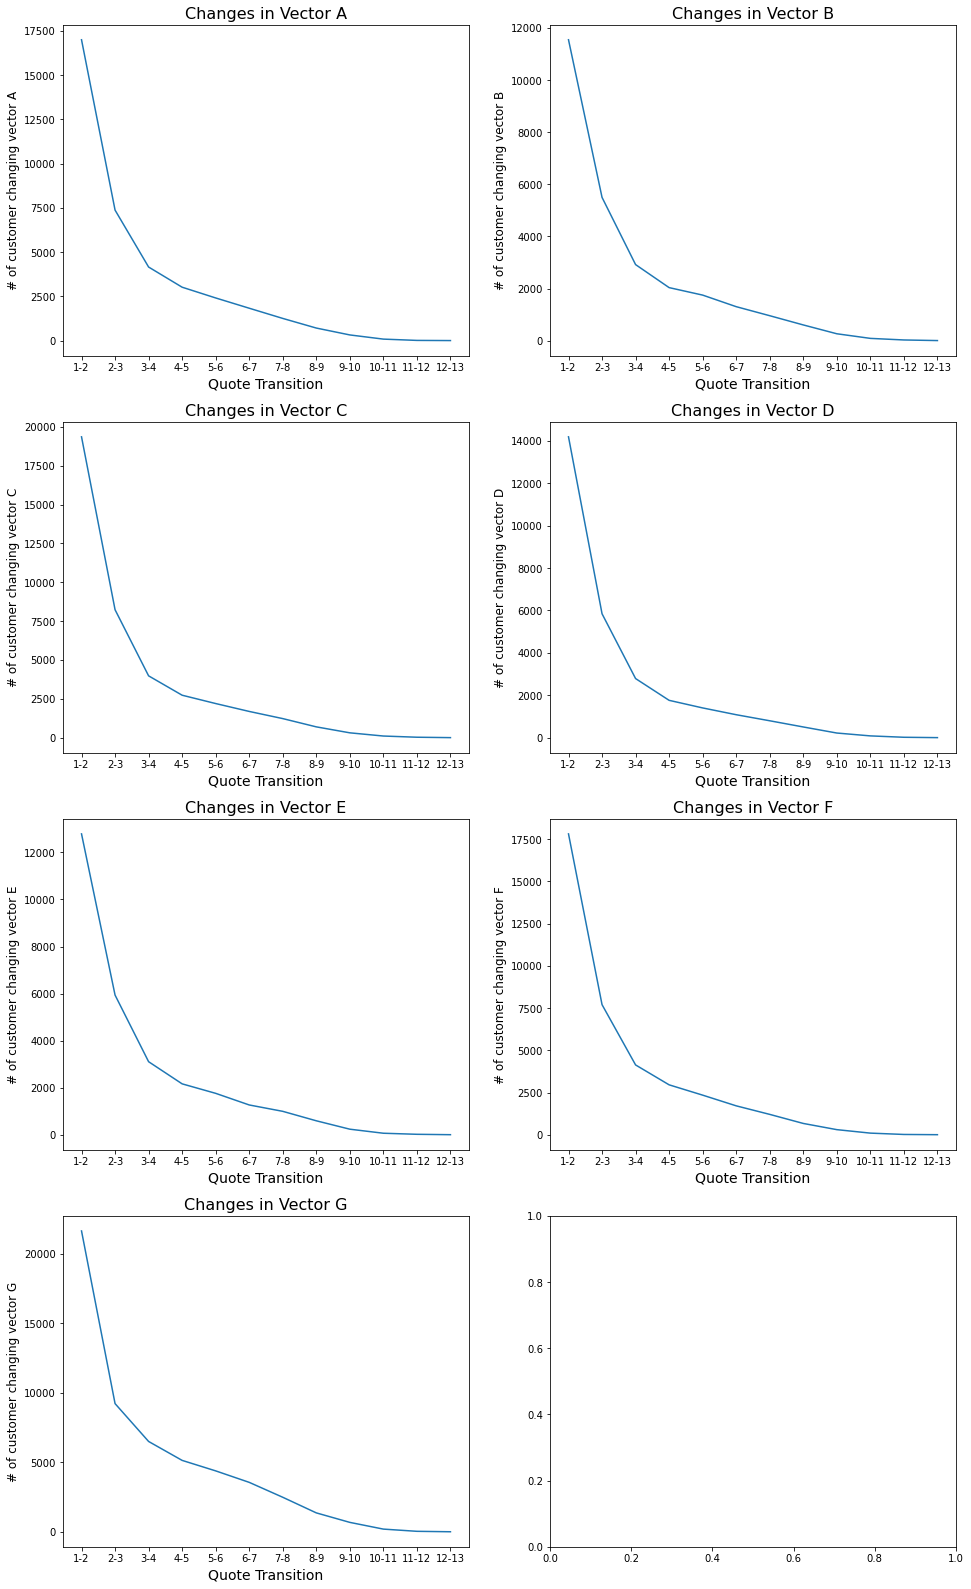

In [42]:
quote_transition = ['1-2', '2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10','10-11','11-12','12-13']

fig, ax = plt.subplots(4,2, figsize=(16,28))

for idx, vector in enumerate(product_vectors):
    ax[idx // 2][idx % 2].plot(quote_transition, count_changes[vector])
    ax[idx // 2][idx % 2].set_xlabel('Quote Transition', fontsize=14)
    ax[idx // 2][idx % 2].set_ylabel('# of customer changing vector '+vector, fontsize=12)
    ax[idx // 2][idx % 2].set_title('Changes in Vector '+vector, fontsize=16)


The above charts for no. of customers making changes at each quote seems to resemble an exponential decay. 
While the no. of customers making changes declines rapidly as they move further in the quote process, the absolute nos. of customers making changes is still in thousands till quotes 8 and 9, so not totally ignorable. 

Let's now get a sense of how many vectors (out of the 7 product vectors) do customers make on average at each quote.


In [46]:

product_vectors = ['A', 'B', 'C','D','E','F','G']

changes_tracker = {}
cust_tracker = df_train[['customer_ID', 'shopping_pt']]

for quote in range(2,14):
    cols_to_select = ['customer_ID']
    
    for vector in product_vectors:
        cols_to_select.append(vector+"_"+str(quote))
        cols_to_select.append(vector+"_"+str(quote-1))
        
    cols_to_compare = df_train[df_train['shopping_pt'] >= quote][cols_to_select]
    
    cols_to_sum = []

    for vector in product_vectors:
    
        # count how many customers changed vector from previous quote to current quote
        cols_to_compare[str(quote)+vector] = np.where(cols_to_compare[vector+'_'+str(quote)] \
                                                       != cols_to_compare[vector+'_'+str(quote-1)], 1, 0)
        
        cols_to_sum.append(str(quote)+vector)
        
    cols_to_compare[str(quote)+'_changes'] = cols_to_compare[cols_to_sum].sum(axis=1)
    
    cust_tracker = cust_tracker.merge(cols_to_compare[['customer_ID', str(quote)+'_changes']], on = 'customer_ID', how='left')
   

In [48]:
cust_tracker_2 = cust_tracker.fillna(0)
cust_tracker_2.sample(5)

,customer_ID,shopping_pt,2_changes,3_changes,4_changes,5_changes,6_changes,7_changes,8_changes,9_changes,10_changes,11_changes,12_changes,13_changes
21557,10113102,6,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14637,10031451,7,2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
36425,10056041,7,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3747,10097914,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75435,10056756,9,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:

change_cols = ['2_changes', '3_changes', '4_changes','5_changes', '6_changes', '7_changes', '8_changes',\
               '9_changes', '10_changes','11_changes', '12_changes', '13_changes']

cust_tracker_2['total_changes'] = cust_tracker_2[change_cols].sum(axis=1)

#avg_changes_per_customer = np.mean(cust_tracker_2['total_changes'])

print('Avg. Changes per customer:', round(np.mean(cust_tracker_2['total_changes']),2))
print('Median Changes per customer:', np.median(cust_tracker_2['total_changes']))


Avg. Changes per customer: 3.32
Median Changes per customer: 3.0


In [104]:
cust_tracker_2[cust_tracker_2['total_changes'] >10]

,customer_ID,shopping_pt,2_change,3_change,4_change,5_change,6_change,7_change,8_change,9_change,10_change,11_change,12_change,13_change,total_changes
95,10118350,7,3,0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
105,10131503,8,6,0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,11.0
198,10093299,7,5,5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
254,10031611,11,3,0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,11.0
279,10017028,9,1,4,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77343,10062796,4,7,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
77362,10031455,8,3,2,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,11.0
77380,10005220,8,7,0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,12.0
77412,10079030,6,4,0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0


In [111]:

customer = pd.DataFrame(df_train[df_train['customer_ID'] == 10031455])

for quote in range(1, 9):
    cols_to_select = ['customer_ID']
    
    for vector in product_vectors:
        cols_to_select.append(vector+"_"+str(quote))
    
    print(customer[cols_to_select])


       customer_ID  A_1  B_1  C_1  D_1  E_1  F_1  G_1
77362     10031455    1    1    3    3    1    2    3
       customer_ID  A_2  B_2  C_2  D_2  E_2  F_2  G_2
77362     10031455    1    0    1    3    0    2    3
       customer_ID  A_3  B_3  C_3  D_3  E_3  F_3  G_3
77362     10031455    0    0    1    3    0    0    3
       customer_ID  A_4  B_4  C_4  D_4  E_4  F_4  G_4
77362     10031455  0.0  0.0  1.0  3.0  0.0  0.0  3.0
       customer_ID  A_5  B_5  C_5  D_5  E_5  F_5  G_5
77362     10031455  0.0  0.0  1.0  3.0  0.0  0.0  3.0
       customer_ID  A_6  B_6  C_6  D_6  E_6  F_6  G_6
77362     10031455  1.0  0.0  1.0  3.0  0.0  2.0  3.0
       customer_ID  A_7  B_7  C_7  D_7  E_7  F_7  G_7
77362     10031455  0.0  0.0  1.0  3.0  0.0  0.0  3.0
       customer_ID  A_8  B_8  C_8  D_8  E_8  F_8  G_8
77362     10031455  1.0  0.0  1.0  3.0  0.0  1.0  3.0


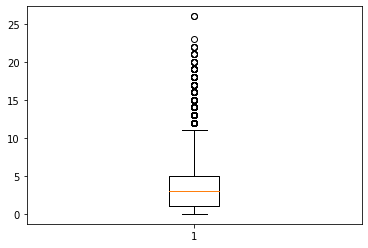

In [102]:
plt.boxplot(cust_tracker_2['total_changes'])
plt.show()

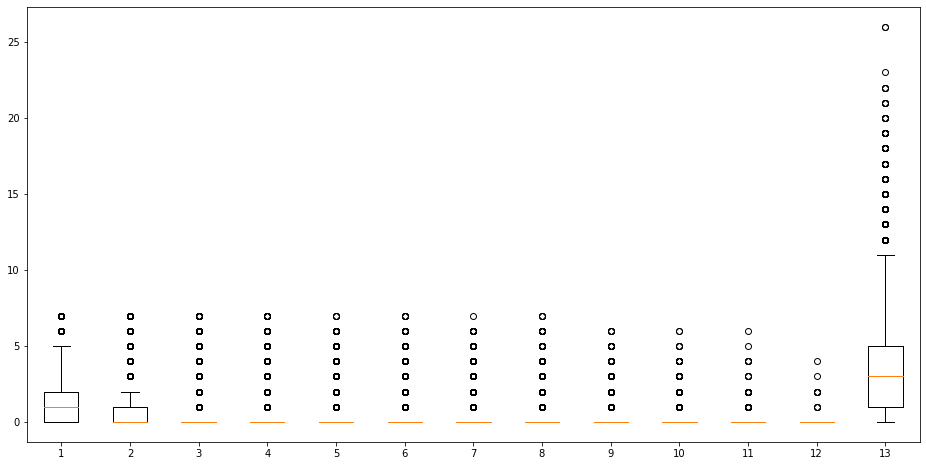

In [113]:
fig, ax = plt.subplots(figsize=(16,8))
ax.boxplot(cust_tracker_2.iloc[:,2:])
plt.show()


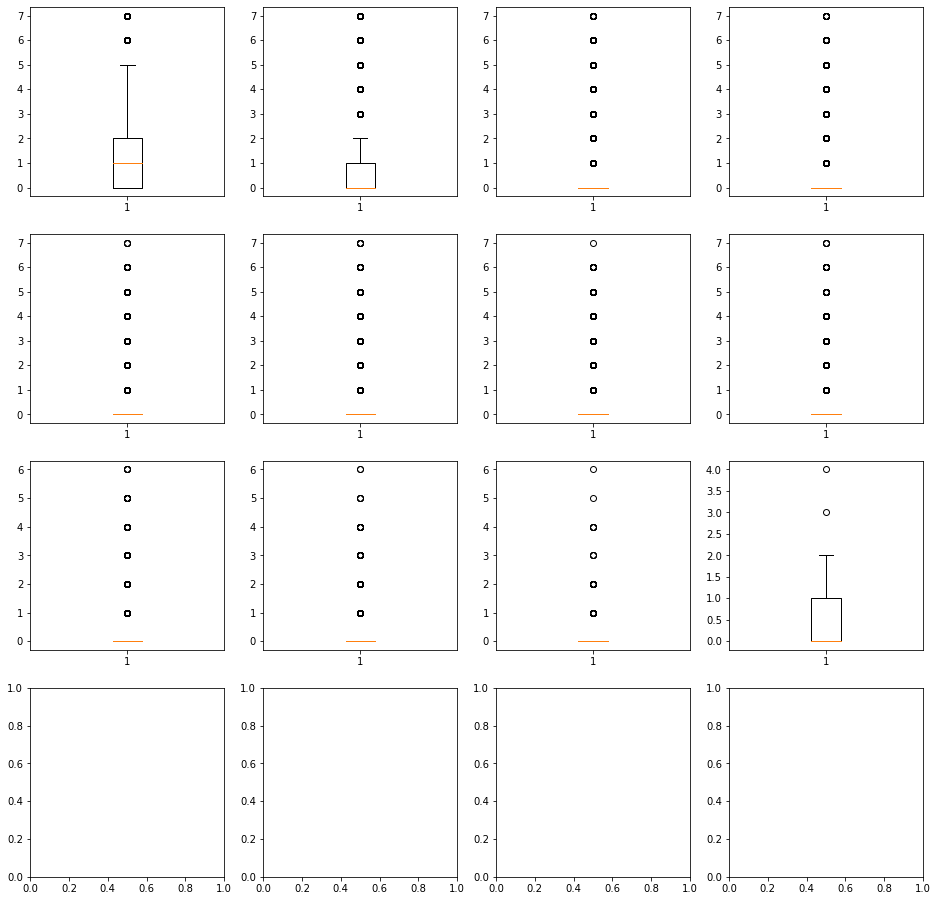

In [118]:

fig, ax = plt.subplots(4,4, figsize=(16,16))

#ax.boxplot(cust_tracker_2.iloc[:,2:])


for quote in range(2,14):
    ax[(quote-2)//4][(quote-2)%4].boxplot(cust_tracker_2[cust_tracker_2['shopping_pt']>=quote].iloc[:,quote])

plt.show()

In [81]:
np.sum(np.where(cust_tracker[cust_tracker['2_change'] !=0]['3_change'] != 0, 1, 0))


14181

In [82]:
np.sum(np.where(cust_tracker[cust_tracker['2_change'] !=0]['3_change'] == 0, 1, 0))


32290

In [83]:
np.sum(np.where(cust_tracker[cust_tracker['2_change'] ==0]['3_change'] != 0, 1, 0))


11180

In [84]:
np.sum(np.where(cust_tracker[cust_tracker['2_change'] ==0]['3_change'] == 0, 1, 0))


19956

In [8]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [9]:

df_train[df_train['shopping_pt'] >= 10].shape


(6980, 259)

In [28]:

cust_10qplus = df_train[df_train['shopping_pt'] >= 10]
product_vectors = ['A', 'B', 'C','D','E','F','G']

for shpng_pt in range(10,14):
    crm_v = {}
    df_temp = cust_10qplus[cust_10qplus['shopping_pt'] == shpng_pt]
    
    crm_v['quotes_'] = [str(x)+"_and_"+str(shpng_pt) for x in range(1,shpng_pt+1)]
    
    for vector in product_vectors:
        crm_v[vector] = []
        
        for quote in range(1, shpng_pt+1):
            crm_v[vector].append(round(cramers_v(df_temp[vector+"_"+str(quote)], df_temp[vector]),3))
            
    
    crm_coeff = pd.DataFrame(crm_v)
    crm_coeff = crm_coeff.set_index('quotes_')
    crm_coeff['Avg.'] = round(crm_coeff.sum(axis = 1) / 7, 3)
    
    print(f'\nCramers V Co-relation for Customers with Shopping Pt = {shpng_pt}')
    print(f'\nNumber of customers = {df_temp.shape[0]}')
    print(crm_coeff)





Cramers V Co-relation for Customers with Shopping Pt = 10

Number of customers = 4857
               A      B      C      D      E      F      G   Avg.
quotes_                                                          
1_and_10   0.308  0.376  0.385  0.422  0.355  0.418  0.443  0.387
2_and_10   0.583  0.594  0.658  0.639  0.597  0.650  0.587  0.615
3_and_10   0.709  0.714  0.772  0.751  0.717  0.749  0.643  0.722
4_and_10   0.772  0.777  0.822  0.806  0.784  0.799  0.688  0.778
5_and_10   0.809  0.814  0.855  0.845  0.824  0.834  0.731  0.816
6_and_10   0.837  0.847  0.874  0.872  0.856  0.858  0.756  0.843
7_and_10   0.857  0.864  0.891  0.884  0.874  0.878  0.781  0.861
8_and_10   0.878  0.885  0.905  0.901  0.894  0.898  0.807  0.881
9_and_10   0.897  0.901  0.920  0.918  0.913  0.912  0.828  0.898
10_and_10  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000

Cramers V Co-relation for Customers with Shopping Pt = 11

Number of customers = 1703
               A      B      C    

In [29]:

product_vectors = ['A', 'B', 'C','D','E','F','G']

for shpng_pt in range(3,10):
    crm_v = {}
    df_temp = df_train[df_train['shopping_pt'] == shpng_pt]
    
    crm_v['quotes_'] = [str(x)+"_and_"+str(shpng_pt) for x in range(1,shpng_pt+1)]
    
    for vector in product_vectors:
        crm_v[vector] = []
        
        for quote in range(1, shpng_pt+1):
            crm_v[vector].append(round(cramers_v(df_temp[vector+"_"+str(quote)], df_temp[vector]),3))
            
    
    crm_coeff = pd.DataFrame(crm_v)
    crm_coeff = crm_coeff.set_index('quotes_')
    crm_coeff['Avg.'] = round(crm_coeff.sum(axis = 1) / 7, 3)
    
    print(f'\nCramers V Co-relation for Customers with Shopping Pt = {shpng_pt}')
    print(f'\nNumber of customers = {df_temp.shape[0]}')
    print(crm_coeff)



Cramers V Co-relation for Customers with Shopping Pt = 3

Number of customers = 4455
             A      B      C      D     E      F      G   Avg.
quotes_                                                       
1_and_3  0.401  0.514  0.491  0.514  0.48  0.492  0.432  0.475
2_and_3  0.739  0.741  0.797  0.783  0.75  0.767  0.672  0.750
3_and_3  1.000  1.000  1.000  1.000  1.00  1.000  1.000  1.000

Cramers V Co-relation for Customers with Shopping Pt = 4

Number of customers = 6401
             A      B      C      D      E      F      G   Avg.
quotes_                                                        
1_and_4  0.389  0.492  0.502  0.505  0.453  0.467  0.421  0.461
2_and_4  0.739  0.736  0.793  0.771  0.742  0.763  0.664  0.744
3_and_4  0.811  0.814  0.867  0.845  0.823  0.834  0.745  0.820
4_and_4  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000

Cramers V Co-relation for Customers with Shopping Pt = 5

Number of customers = 9015
             A      B      C      D      E 

In [49]:
cols=['customer_ID']

for vector in product_vectors:
    for quote in range(1,3):
        cols.append(vector+"_"+str(quote))


df_temp = df_train[cols]

df_temp.head()

,customer_ID,A_1,A_2,B_1,B_2,C_1,C_2,D_1,D_2,E_1,E_2,F_1,F_2,G_1,G_2
0,10109793,1,1,0,0,3,3,3,3,0,0,2,2,1,1
1,10002231,1,0,0,0,1,1,1,3,0,0,2,0,3,3
2,10150024,2,2,0,0,3,3,3,3,0,0,3,3,3,3
3,10003949,1,1,1,1,2,2,2,2,1,1,2,2,4,3
4,10103809,1,1,1,1,2,1,3,3,1,1,1,1,4,3


In [40]:
pd.merge?

In [6]:
# Now's let's check the shopping_pt column to see how much history is available for these customers 

no_of_cust_by_shpng_pt = pd.DataFrame(test_data.groupby("shopping_pt")["customer_ID"].nunique())
no_of_cust_by_shpng_pt.columns = ["#Customers"]
no_of_cust_by_shpng_pt["%_of_Customers"] = no_of_cust_by_shpng_pt["#Customers"] *100/ no_of_cust_by_shpng_pt["#Customers"].max()
no_of_cust_by_shpng_pt


,#Customers,%_of_Customers
shopping_pt,,
1,55716,100.000000
2,55716,100.000000
3,36773,66.000790
4,23475,42.133319
5,14224,25.529471
6,7696,13.812908
7,3493,6.269294
8,1318,2.365568
9,359,0.644339


So for all customers atleast 2 shopping quotes are provided. This then drops rapidly. For only ~14% customers, 6 quotes are available. Let's see what is the average no. of quotes available.


In [7]:
np.average(test_data.groupby("customer_ID")["shopping_pt"].max())

3.569100437935243

On an average 3 to 4 quotes are available for a customer. This has implications for model development and training which we shall discuss in subsequent sections 

In [8]:
test_data.isna().sum()

customer_ID              0
shopping_pt              0
record_type              0
day                      0
time                     0
state                    0
location               678
group_size               0
homeowner                0
car_age                  0
car_value              739
risk_factor          75487
age_oldest               0
age_youngest             0
married_couple           0
C_previous            9769
duration_previous     9769
A                        0
B                        0
C                        0
D                        0
E                        0
F                        0
G                        0
cost                     0
dtype: int64

So the test data has large missing values for risk_factor, C_previous and duration_previous. For car_value and location a very small amount of missing values exist. We shall keep this is mind while analysing these variables. 


## 2.4 Categorical and Date/Time Variables<a id='2.3_Categorical_Variables'></a>


In this section we shall decide 

1) what to do with categorical variables like state, location etc. Should we keep them or remove them?

2) What to do with time variable ? Does time gap between two successive quotes impact the quantum of changes made by a customer ?

3) How to handle day variable. It is currently encoded numerically from 0-6, but this encoding doesn't reflect 'time_gap' correctly. E.g The 'time_gap' between a Monday and Sunday is 1 day, but the current encoding separates them by 6, as Monday is encoded 0 and Sunday is encoded 6. Also, as dates are not provided, there is no way to know the no. of days separating customer shopping instances. E.g. say in a customer's shopping history, day column shows 1 (Tuesday) for certain quotes and 3(Thursday) for some other quotes. There is no way to know whether the Thursday was in the same week or the any subsequent week. For this reason, it is also difficult to estimate time_gap between quotes on two separate days.



## 2.4.1 State<a id='2.4.1_State'></a>

Let's start by looking at state and understanding what kind of interactions they have with the final product vectors.


In [9]:
#Let's check the distribution of customers by state

state_dist = pd.DataFrame(df_wide.groupby("state")["customer_ID"].nunique().sort_values(ascending=False))

state_dist.columns = ["#Customers"]
state_dist

,#Customers
state,
FL,14605
NY,13661
PA,8953
OH,6664
MD,4222
IN,3749
AL,3595
WA,3575
CO,3540


In [10]:
# To understand whether state makes an impact on the product vectors, let's check the distribution of a couple of product
# vectors across states. Let's check product vector B as it has only two values - 0 and 1.
# We define vector_b_ratio which is the % of customers selecting 1 for vector B

vector_b_ratio = df_wide.pivot_table(values = "B", index = "state")

state_dist = state_dist.merge(vector_b_ratio, on="state")

state_dist.sort_values(by="B")

,#Customers,B
state,,
ND,382,0.104712
CT,2836,0.216502
ME,1011,0.218595
RI,878,0.257403
NM,1000,0.338000
OK,2023,0.350964
SD,82,0.365854
NH,1136,0.371479
PA,8953,0.382107


The above tables provided the ratio of customers in a particular state who chose the value 1 for vector B. 
We can see that it ranges from ~10% for North Dakota to as high as 73% for Tennessee. Florida, the state with most no. of 
customers is at 47%. 

At first sight this seems like a large variation. But this could just be the effect of random sampling.
Let's look at some summary statistics.


In [11]:
state_dist["B"].describe()

count    36.000000
mean      0.474517
std       0.141527
min       0.104712
25%       0.386897
50%       0.478840
75%       0.554400
max       0.729842
Name: B, dtype: float64

So the mean is 0.47 and standard deviation is 0.14. The maximum value of 0.73 is within 2 standard deviations from the mean, while the minimum value of 0.104 is within 3 standard deviations of the mean. Let's look at the histogram to graphically see the distribution.

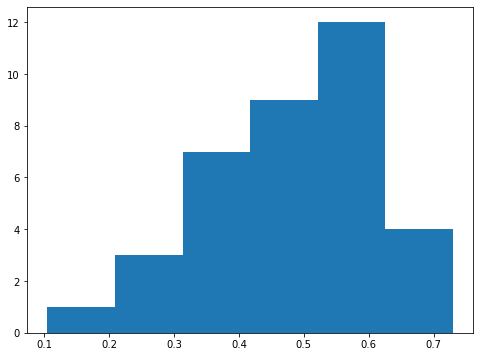

In [12]:
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(vector_b_ratio["B"], bins = 6)
plt.show()

The distribution seems left_tailed, with very few states having a ratio less than 30%. Let's look at a boxplot.

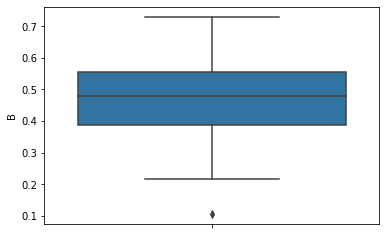

In [13]:
sns.boxplot(y="B", data=vector_b_ratio)
plt.show()

So half of the states are ranging from 38% to 55%, with the sole outlier being North Dakota.  

Let's do hypothesis testing to answer the question - Are states different from each other when it comes to selecting Vector B?

Let's say the **null hypothesis** is that "States are not different from each other when it comes to selecting Vector B".
If we can prove that any two states are significantly different from each other, then the null hypothesis will not hold.  
So let's select a pair of states with similar no. of customers but seemingly very different Vector B ratio. 




In [14]:
state_dist.sort_values(by="#Customers", ascending=False)

,#Customers,B
state,,
FL,14605,0.473810
NY,13661,0.439499
PA,8953,0.382107
OH,6664,0.429772
MD,4222,0.554950
IN,3749,0.522539
AL,3595,0.717942
WA,3575,0.473846
CO,3540,0.553672


Connecticut(2836) and Tennessee (2654) have similar no. of customers, but very different Vector_B ratio's of 0.216 and 0.729 respectively. The difference in this ratio is 0.729 - 0.216, i.e 0.513. 
To do the hypothesis testing, let's use the permutation resampling technique. 

1) Select only the customers from these two states and their B vector.

2) Randomly permute the B vector.

3) Select the first 2836 as Connecticut and the rest as Tennessee. Calculate the difference in Vector B_ratio.

4) Do this 10,000 times. Then see if the difference of 0.513 is significant or not.

In [15]:
CT_TN_customers = df_wide[df_wide["state"].isin(['CT', 'TN'])].loc[:, ["state", "B"]]

CT_TN_customers.head()

,state,B
30,CT,0
42,CT,0
48,CT,0
63,TN,0
65,TN,0


In [16]:
CT_TN_customers.shape

(5490, 2)

In [17]:

B_vector = CT_TN_customers["B"]
diff_B_ratio = np.empty(10000)

for i in range(10000):
    permuted_B_vector = np.random.permutation(B_vector)
    permuted_B_vector_CT = permuted_B_vector[:2836]
    permuted_B_vector_TN = permuted_B_vector[2836:]
 
    diff_B_ratio[i] = np.mean(permuted_B_vector_TN) - np.mean(permuted_B_vector_CT)

   

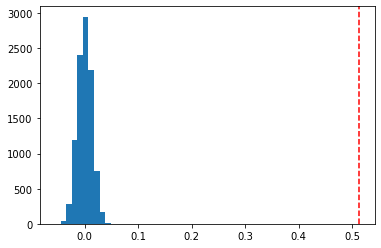

In [18]:
plt.hist(diff_B_ratio)
plt.axvline(0.513, c='r', linestyle="--")
plt.show()

So we can see that the observed difference in B vector ratios of 0.513 is completely beyond the random distribution of B_vector ratio differences if the state were similar. That means the **p_value = 0**. This leads us to conclude that Tennessee and Connecticut are not similar when it comes to selecting B vector.

Let's check for another pair of states. This time we will select states with very different customer nos. as well as different B_vector ratio.

Let's take Maryland (4222 customers, 0.5549 B_vector ratio) and New Mexico (1000 customers, 0.338 B_vector ratio).
The diff. in B_vector ratio is 0.5549 - 0.338 i.e 0.2169. 

Let's test the null hypothesis that MD and NM are not significantly different.


In [19]:
MD_NM_customers = df_wide[df_wide["state"].isin(['MD', 'NM'])].loc[:, ["state", "B"]]

MD_NM_customers.head()

,state,B
40,NM,0
45,NM,0
49,MD,1
53,NM,1
56,NM,0


In [20]:
MD_NM_customers.shape


(5222, 2)

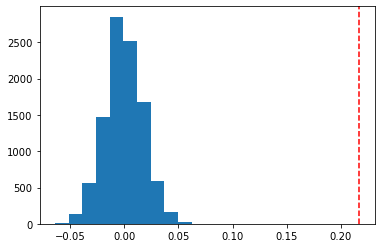

In [21]:

B_vector = MD_NM_customers["B"]
diff_B_ratio = np.empty(10000)

for i in range(10000):
    permuted_B_vector = np.random.permutation(B_vector)
    permuted_B_vector_MD = permuted_B_vector[:4222]
    permuted_B_vector_NM = permuted_B_vector[4222:]
 
    diff_B_ratio[i] = np.mean(permuted_B_vector_MD) - np.mean(permuted_B_vector_NM)
    

plt.hist(diff_B_ratio)
plt.axvline(0.2169, c='r', linestyle="--")
plt.show()


Again we can see that the observed difference in B vector ratios of 0.2169 is completely beyond the random distribution of B_vector ratio differences if the states were similar. This leads us to conclude that Maryland and New Mexico are not similar when it comes to selecting B vector.

Let's check for another vector. Let's take vector E.


In [22]:
vector_E_ratio = df_wide.pivot_table(values = "E", index = "state")

state_dist = state_dist.merge(vector_E_ratio, on="state")

state_dist


,#Customers,B,E
state,,,
FL,14605,0.473810,0.588223
NY,13661,0.439499,0.530927
PA,8953,0.382107,0.534793
OH,6664,0.429772,0.411915
MD,4222,0.554950,0.579583
IN,3749,0.522539,0.380635
AL,3595,0.717942,0.368846
WA,3575,0.473846,0.336783
CO,3540,0.553672,0.348305


In [23]:
state_dist["E"].describe()

count    36.000000
mean      0.387552
std       0.135847
min       0.049738
25%       0.297904
50%       0.369891
75%       0.516617
max       0.588223
Name: E, dtype: float64

Again we observe a wide variation in Vector_E ratios across states. Let check whether North Dakota (382 cusotmer, 0.0497 vector_E ratio) is different from Nebraska (490 customers, 0.265 vector_E ratio).
The diff. in E_vector ratio is 0.265 - 0.0497 i.e 0.2156. Let's see is this differnce would occur if the states were similar by doing permutation resampling 10,000 times.

In [24]:

ND_NE_customers = df_wide[df_wide["state"].isin(['ND', 'NE'])].loc[:, ["state", "E"]]

ND_NE_customers.head()


,state,E
133,NE,1
157,ND,1
329,NE,0
335,ND,0
340,ND,0


In [25]:
ND_NE_customers.shape

(872, 2)

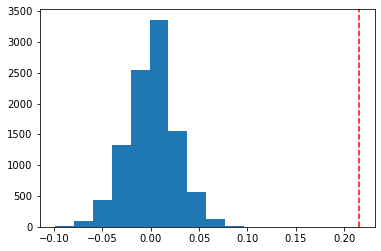

In [26]:
E_vector = ND_NE_customers["E"]
diff_E_ratio = np.empty(10000)

for i in range(10000):
    permuted_E_vector = np.random.permutation(E_vector)
    permuted_E_vector_ND = permuted_E_vector[:382]
    permuted_E_vector_NE = permuted_E_vector[382:]
 
    diff_E_ratio[i] = np.mean(permuted_E_vector_ND) - np.mean(permuted_E_vector_NE)
    

plt.hist(diff_E_ratio)
plt.axvline(0.2156, c='r', linestyle="--")
plt.show()

The observed difference of 0.2156 is completely outside the distribution of vector_E ratio difference if the states were similar. Clearly, North Dakota and Nebraska customers behave differently while seclecting vector E. 

Let's do it for one more pair of states - Tennesse (2654 customers, 0.585 vector_E ratio) and Kentucky (2369 customers, 0.357 vector_E ratio). The difference in ratio is 0.585 - 0.357 = 0.228

In [27]:
TN_KY_customers = df_wide[df_wide["state"].isin(['TN', 'KY'])].loc[:, ["state", "E"]]

TN_KY_customers.head()


,state,E
63,TN,0
65,TN,1
95,KY,1
109,TN,0
118,TN,1


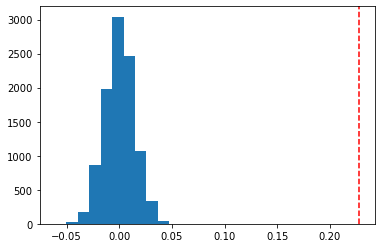

In [28]:
E_vector = TN_KY_customers["E"]
diff_E_ratio = np.empty(10000)

for i in range(10000):
    permuted_E_vector = np.random.permutation(E_vector)
    permuted_E_vector_TN = permuted_E_vector[:2654]
    permuted_E_vector_KY = permuted_E_vector[2654:]
 
    diff_E_ratio[i] = np.mean(permuted_E_vector_TN) - np.mean(permuted_E_vector_KY)
    

plt.hist(diff_E_ratio)
plt.axvline(0.228, c='r', linestyle="--")
plt.show()


Based on the above analysis, its clear that some state are distinctly different from others in selection of product vectors.
As such, let's keep state as a variable for the model.


## 2.4.2 Location<a id='2.4.2_Location'></a>



In [29]:

location_dist = pd.DataFrame(df_wide.groupby("location")["customer_ID"].nunique().sort_values(ascending=False))

location_dist.columns = ["#Customers"]
location_dist.head()


,#Customers
location,
10083,152
10348,136
11196,133
10213,124
11517,117


In [70]:
location_dist[location_dist['#Customers'] > 50].sum()

#Customers    10671
dtype: int64

In [31]:
location_dist.shape

(6219, 1)

In [32]:
location_dist.tail()

,#Customers
location,
15712,1
15719,1
15727,1
15728,1
16580,1


There are 6219 different locations or zip codes in the dataset of 97009 customers. That means on an average each location has 97009/6219 customers or ~16 customers. As we can see from the tail of the location distribution, many locations have only 1 customer. Trying to learn something for a location with 1 customer will be futile and add unneccessary complexity to the model. 

As such, we shall drop location as a variable from the model. 


## 2.4.3 Day<a id='2.4.3_Day'></a>


Let's look at the day variable to understand how they are distributed and whether they have an impact on product vectors.


In [33]:
day_dist = pd.DataFrame(df_wide.groupby("day")["customer_ID"].nunique().sort_values(ascending=False))

day_dist.columns = ["#Customers"]
day_dist

,#Customers
day,
4,20851
1,19244
2,18825
0,18583
3,17954
5,1433
6,119


The no. of customers are evenly distributed from day 0-5 (Mon-Fri) and drop sharply on the weekends (day 5-6). 

So let's consider Mon-Fri and see if there are any observable difference in product vectors across days. Let's do it again with vector B, given it has only two values - 0 or 1. 

In [34]:
vector_b_ratio = df_wide.pivot_table(values = "B", index = "day")

day_dist = day_dist.merge(vector_b_ratio, on="day")

day_dist

,#Customers,B
day,,
4,20851,0.474078
1,19244,0.484047
2,18825,0.479309
0,18583,0.467416
3,17954,0.474546
5,1433,0.484997
6,119,0.512605


In [35]:
vector_e_ratio = df_wide.pivot_table(values = "E", index = "day")

day_dist = day_dist.merge(vector_e_ratio, on="day")

day_dist.sort_index()

,#Customers,B,E
day,,,
0,18583,0.467416,0.464295
1,19244,0.484047,0.466379
2,18825,0.479309,0.466985
3,17954,0.474546,0.462460
4,20851,0.474078,0.451921
5,1433,0.484997,0.477320
6,119,0.512605,0.613445


Looking at the Mon-Fri distribution of vector B, the max. difference is between Mon (0.4674) and Tue(0.4840). 
The diff. is 0.484047 - 0.467416 =  0.0166. Let's use the same permutation resampling method to understand if this difference is significant.

Null Hypothesis: There is no significant difference in vector_B ratio between different days.

Before we test this hypothesis, let's decide the p_value to signal significance. For comparing any two days from Mon-Fri, there are 5C2 = 10 different combinations possible, so cut-off p_value should be 0.01/10 i.e **0.001**. 


In [36]:
Mon_Tue_customers = df_wide[df_wide["day"].isin([0, 1])].loc[:, ["day", "B"]]

Mon_Tue_customers.sample(10)

,day,B
42302,1,1
64811,0,0
48903,1,0
31488,0,1
72066,0,0
94058,0,0
29550,0,0
21840,0,0
59375,1,0
89209,0,0


In [37]:
Mon_Tue_customers.shape

(37827, 2)

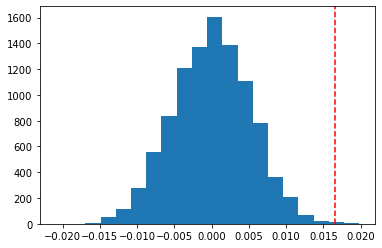

In [38]:
B_vector = Mon_Tue_customers["B"]
diff_B_ratio = np.empty(10000)

for i in range(10000):
    permuted_B_vector = np.random.permutation(B_vector)
    permuted_B_vector_Mon = permuted_B_vector[:18583]
    permuted_B_vector_Tue = permuted_B_vector[18583:]
 
    diff_B_ratio[i] = np.mean(permuted_B_vector_Tue) - np.mean(permuted_B_vector_Mon)
    

plt.hist(diff_B_ratio, bins = 20)
plt.axvline(0.0166, c='r', linestyle="--")
plt.show()

 Visually, the observed difference of 0.0166 indicated by red line does look extreme. LEt's calculate it's p_value.
 

In [39]:
p_value = np.sum(diff_B_ratio > 0.0166)/ len(diff_B_ratio)
print(p_value)

0.0005


The p_value in this case of 0.0007 is lower than 0.001, so the result does seems significant i.e. the Mon and Tue behave significantly different when it comes to choice of B vector.

Let's do the same for each pair of days (Mon-Wed), (Mon-Thurs), (Mon-Fri), (Tue-Wed) and so on..

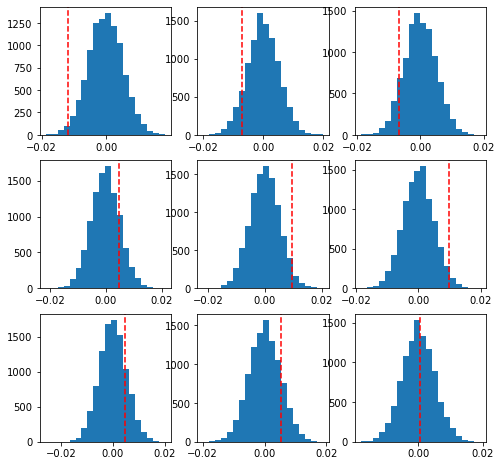

In [40]:

fig, ax = plt.subplots(3,3, figsize = (8,8))

day_combinations = [[0,2],[0,3],[0,4],[1,2],[1,3],[1,4],[2,3],[2,4],[3,4]]
p_values = np.empty(9)

for i in range(9):
    customers_subset = df_wide[df_wide["day"].isin(day_combinations[i])].loc[:, ["day", "B"]]
    
    day_1 = day_combinations[i][0]
    day_2 = day_combinations[i][1]
    
    no_of_customers_day_1 = day_dist.loc[day_1, "#Customers"]
    no_of_customers_day_2 = day_dist.loc[day_2, "#Customers"]
           
    B_vector = customers_subset["B"]
    diff_B_ratio = np.empty(10000)
    
    for j in range(10000):
        permuted_B_vector = np.random.permutation(B_vector)
        permuted_B_vector_day_1 = permuted_B_vector[:no_of_customers_day_1]
        permuted_B_vector_day_2 = permuted_B_vector[no_of_customers_day_1:]
 
        diff_B_ratio[j] = np.mean(permuted_B_vector_day_1) - np.mean(permuted_B_vector_day_2)
    
    actual_diff = day_dist.loc[day_1, "B"] - day_dist.loc[day_2, "B"]
    
    
    ax[i//3][i%3].hist(diff_B_ratio, bins = 20)
    ax[i//3][i%3].axvline(actual_diff, c='r', linestyle="--")
    
    if actual_diff > 0:
        p_values[i] = np.sum(diff_B_ratio > actual_diff)/ len(diff_B_ratio)
    else:
        p_values[i] = np.sum(diff_B_ratio < actual_diff)/ len(diff_B_ratio)
    

plt.show()


In [41]:
print(p_values)
print("No. of p_value's less than 0.001-->", np.sum(p_values < 0.001))


[0.0134 0.088  0.0945 0.1682 0.0319 0.0251 0.1771 0.1562 0.4573]
No. of p_value's less than 0.001--> 0


None of the other 9 p_values are significant, indicating that the observed difference in vector_B ratio between different days are not extreme. 

Let's repeat this for vector E.

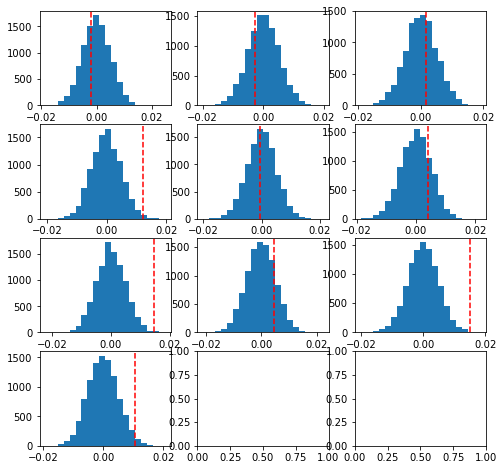

In [42]:
fig, ax = plt.subplots(4,3, figsize = (8,8))

day_combinations = [[0,1], [0,2],[0,3],[0,4],[1,2],[1,3],[1,4],[2,3],[2,4],[3,4]]
p_values = np.empty(10)

for i in range(10):
    customers_subset = df_wide[df_wide["day"].isin(day_combinations[i])].loc[:, ["day", "E"]]
    
    day_1 = day_combinations[i][0]
    day_2 = day_combinations[i][1]
    
    no_of_customers_day_1 = day_dist.loc[day_1, "#Customers"]
    no_of_customers_day_2 = day_dist.loc[day_2, "#Customers"]
           
    E_vector = customers_subset["E"]
    diff_E_ratio = np.empty(10000)
    
    for j in range(10000):
        permuted_E_vector = np.random.permutation(E_vector)
        permuted_E_vector_day_1 = permuted_E_vector[:no_of_customers_day_1]
        permuted_E_vector_day_2 = permuted_E_vector[no_of_customers_day_1:]
 
        diff_E_ratio[j] = np.mean(permuted_E_vector_day_1) - np.mean(permuted_E_vector_day_2)
    
    actual_diff = day_dist.loc[day_1, "E"] - day_dist.loc[day_2, "E"]
    
    
    ax[i//3][i%3].hist(diff_E_ratio, bins = 20)
    ax[i//3][i%3].axvline(actual_diff, c='r', linestyle="--")
    
    if actual_diff > 0:
        p_values[i] = np.sum(diff_E_ratio > actual_diff)/ len(diff_E_ratio)
    else:
        p_values[i] = np.sum(diff_E_ratio < actual_diff)/ len(diff_E_ratio)
    

plt.show()


In [43]:
print(p_values)
print("No. of p_value's less than 0.001-->", np.sum(p_values < 0.001))

[0.3354 0.2912 0.3632 0.0055 0.4451 0.2239 0.0023 0.1846 0.001  0.0195]
No. of p_value's less than 0.001--> 0


None of the p_values are significant, indicating that the observed difference in vector_E ratio between different days are not extreme.

As such, we see that different days are not very different when it comes to selection of product vectors by customers. Consequently, we drop **'day'** as a variable. 




## 2.4.4 Time<a id='2.4.4_Time'></a>


A look at the time variable indicates there are 1204 different values, almost 1 for each minute in the day! (a day has 1440 minutes). Common sense suggests that time is unlikely to impact choice of vectors. While time_gap could be an indicator of possibility of change in vector, for reasons discussed earlier, it is not possible to calculate time_gap for two successive quotes on different days, as 'date' is not available.

Consequently, we shall drop **'time'** as a variable as well.




## 2.4.5 Car Value<a id='2.4.5_Car_Value'></a>

     
In the data wrangling stage, car value values of 'a' to 'g' were changed to numerical values 1-9, as analysis of car_value vs cost suggested and increasing trend of cost from 'a' to 'g'. We will keep car_value as a numercial variable in model development.


## 2.4.6 Risk Factor<a id='2.4.6_Risk_Factor'></a>
    
This is an ordinal assessment of the customer by All State. Let's see how risk_factor is related with vector B and E. 


In [44]:
risk_dist = pd.DataFrame(df_wide.groupby("risk_factor", dropna=False)["customer_ID"].nunique())

risk_dist.columns = ["#Customers"]

vector_b_ratio = pd.DataFrame(df_wide.groupby("risk_factor", dropna=False)["B"].mean())
vector_e_ratio = pd.DataFrame(df_wide.groupby("risk_factor", dropna=False)["E"].mean())

risk_dist = risk_dist.merge(vector_b_ratio, on="risk_factor")
risk_dist = risk_dist.merge(vector_e_ratio, on="risk_factor")

risk_dist

,#Customers,B,E
risk_factor,,,
1.0,14797,0.491451,0.590660
2.0,14384,0.477684,0.540879
3.0,17593,0.472063,0.442847
4.0,16641,0.489394,0.459347
NaN,33594,0.464160,0.384652


While B_vector ratios are not very different across customer's with different 'risk_factor' values, the E_vector ratios do seem very different. As there are a large no. of customer for which risk_factor is not available, we have two options:

1) Impute a value. 
2) Drop risk_factor from the list of independent variables.

The most frequent value of risk_factor is 3.0 at 17,593. Out of the customers with known risk (97009 - 33594 = 63415), this is only 27.7%. Imputing missing values with a value that occurs only a quarter of the time doesn't make intuitive sense. Let's check what component of the test data has missing risk_factors. If its missing for a large no. of customers, then we shall drop it.


In [45]:
test_data.isna().sum()

customer_ID              0
shopping_pt              0
record_type              0
day                      0
time                     0
state                    0
location               678
group_size               0
homeowner                0
car_age                  0
car_value              739
risk_factor          75487
age_oldest               0
age_youngest             0
married_couple           0
C_previous            9769
duration_previous     9769
A                        0
B                        0
C                        0
D                        0
E                        0
F                        0
G                        0
cost                     0
dtype: int64

Risk factor is missing a lot in test set as well! We know that there are atleast two quotes available per customer. Let's check for how many customers, risk factor is not available at all.


In [46]:
risk_test_data = pd.DataFrame(test_data.groupby("risk_factor", dropna=False)["customer_ID"].nunique())

risk_test_data.columns = ["#Customers"]

risk_test_data


,#Customers
risk_factor,
1.0,8365
2.0,7877
3.0,10010
4.0,8874
NaN,21833


So the risk factor is missing for 21833/55716 i.e. **39%** of the customers in the test set!
This is extremely high. We cannot consider a variable that is missing for ~40% of test data. 
So let's drop it from the model development. 


## 2.4.7 C_Previous<a id='2.4.7_C_Previous'></a>


Next we look at **C_previous**. This is the current or past value of vector 'C' for a customer. It has a high corelation with product vector C, as the heatmap in the profiling report showed. Let's check if vector's B and E have different ratios for different C_previous values.


In [47]:
C_prev_dist = pd.DataFrame(df_wide.groupby("C_previous", dropna=False)["customer_ID"].nunique())
C_prev_dist.columns = ["#Customers"]

vector_b_ratio = pd.DataFrame(df_wide.groupby("C_previous", dropna=False)["B"].mean())
vector_e_ratio = pd.DataFrame(df_wide.groupby("C_previous", dropna=False)["E"].mean())

C_prev_dist = C_prev_dist.merge(vector_b_ratio, on="C_previous")
C_prev_dist = C_prev_dist.merge(vector_e_ratio, on="C_previous")

C_prev_dist

,#Customers,B,E
C_previous,,,
1.0,25292,0.449826,0.378934
2.0,16314,0.498468,0.428957
3.0,40471,0.482914,0.506066
4.0,14228,0.485381,0.538375
NaN,704,0.321023,0.218750


Again, while B_vector ratios don't seem very different across customer's with different **'C_previous'** values, the E_vector ratios do seem very different. So let's keep **'C_previous'** as a categorical variable.

Also notice that C_previous is missing for 704 customers. Amongst known C_previous values, C=3 occurs 40,471/97009 i.e. 42% of the time. So for customers with missing C_previous value, we shall impute it to '3'.

 
 

## 2.4.8 Group_Size<a id='2.4.8_Group_Size'></a>




In [48]:
group_size_dist = pd.DataFrame(df_wide.groupby("group_size", dropna=False)["customer_ID"].nunique())
group_size_dist.columns = ["#Customers"]

vector_b_ratio = pd.DataFrame(df_wide.groupby("group_size", dropna=False)["B"].mean())
vector_e_ratio = pd.DataFrame(df_wide.groupby("group_size", dropna=False)["E"].mean())

group_size_dist = group_size_dist.merge(vector_b_ratio, on="group_size")
group_size_dist = group_size_dist.merge(vector_e_ratio, on="group_size")

group_size_dist

,#Customers,B,E
group_size,,,
1,75650,0.469993,0.455188
2,19971,0.496169,0.494968
3,1278,0.517997,0.396714
4,110,0.536364,0.454545


A very large no. of group_size values are 1 i.e. car policy being taken by a single individual. The B and E Vector ratios for different group sizes do exhibit some difference, so we should keep group_size as a 'categorical' variable.

But before we do that, let's check the interaction between group_size and married_couple as the information contained in these two variables could be similar. 


In [49]:
group_size_vs_married = pd.crosstab(df_wide["group_size"], df_wide["married_couple"])
group_size_vs_married


married_couple,0,1
group_size,,
1,72510,3140
2,3861,16110
3,96,1182
4,6,104


While a large no. of group_size 1 customers have married_couple value as 0, some of them do have 1. That mean's policy is being
taken for a one person who is married.
Similarly, not all cases of group_size 2 and 3 are for married couples. As such, we shall keep group_size as a categorical variable.



## 2.4.9 Categorical variables - conclusion<a id='2.4.9_Categorical_variables_conclusion'></a>

After analysing all the categorical and day/time variables, the following variables would be kept in the model:

1) State: No missing values

2) group_size: No missing values

3) C_previous: We would impute the missing C_previous values as 3, since this occurs most frequently (40% of the time) in the training dataset.

4 variables that are being **dropped** from the model are - Location, Day, Time, risk_factor





## 2.5 Numerical Variables<a id='2.5_Numerical_Variables'></a>


There were 6 Numerical variables identified during Data wrangling - shopping_pt, group_size, car_age, age_oldest and age_youngest, duration_previous & cost

Let's start with shopping pt and its distribution.


## 2.5.1 shopping_pt<a id='2.5.1_shopping_pt'></a>



In [50]:
shopping_pt_dist = pd.DataFrame(df_wide.groupby("shopping_pt", dropna=False)["customer_ID"].nunique())
shopping_pt_dist.columns = ["#Customers"]

shopping_pt_dist["%_of_Customers"] = shopping_pt_dist["#Customers"] *100/ shopping_pt_dist["#Customers"].sum()
shopping_pt_dist = shopping_pt_dist.reset_index()
shopping_pt_dist


,shopping_pt,#Customers,%_of_Customers
0,3,5568,5.739674
1,4,8001,8.247688
2,5,11269,11.616448
3,6,15623,16.104691
4,7,18590,19.163170
5,8,17248,17.779794
6,9,11985,12.354524
7,10,6071,6.258182
8,11,2129,2.194642
9,12,475,0.489645


7 is the most common no. of shopping_pts, followed by 8 and 6 respectively. 53.5% of the customers fall across these 3 shopping_pt values. LEt's calculate the average shopping_pt. This no. will give us a sense of how many quotes on average does a customer take before buying the policy.

In [51]:
shpng_pt_average = np.sum(shopping_pt_dist["#Customers"] * shopping_pt_dist["shopping_pt"]) / shopping_pt_dist["#Customers"].sum()
shpng_pt_average

6.857600841159067

So on average it take a customer 7 quotes to decide what policy he/she is going to buy.


In [52]:

vector_b_ratio = pd.DataFrame(df_wide.groupby("shopping_pt", dropna=False)["B"].mean())
vector_e_ratio = pd.DataFrame(df_wide.groupby("shopping_pt", dropna=False)["E"].mean())

shopping_pt_dist = shopping_pt_dist.merge(vector_b_ratio, on="shopping_pt")
shopping_pt_dist = shopping_pt_dist.merge(vector_e_ratio, on="shopping_pt")

shopping_pt_dist

,shopping_pt,#Customers,%_of_Customers,B,E
0,3,5568,5.739674,0.482220,0.466954
1,4,8001,8.247688,0.480315,0.470691
2,5,11269,11.616448,0.464194,0.449641
3,6,15623,16.104691,0.468860,0.446521
4,7,18590,19.163170,0.469016,0.446208
5,8,17248,17.779794,0.481389,0.468112
6,9,11985,12.354524,0.484189,0.478515
7,10,6071,6.258182,0.486905,0.493988
8,11,2129,2.194642,0.503053,0.511508
9,12,475,0.489645,0.477895,0.528421



B_vector and E_vector ratios don't seem very different across a majority of the shopping_pts.

Intuitively though, shopping pt could indicate the propensity of a customer to experiment with new vector values.
Early on in the shopping cycle i.e. for low shopping_pt values, customers might still be in exploratory stage and therefore 
the likelihood of a vector change is higher. For higher shopping_pt values, the likelihood of a vector change could be lower.

Let's check this hunch. To do so, we will compare shopping_pt = 2 and shopping_pt = 5 for Vectors A,B,C and 
see what % of customers change the vector value after shopping_pt = 2 and shopping_pt = 5 respectively.



In [53]:

B_vector_at_shpt_2_and_final_purchase = df_wide.loc[:,["customer_ID", "B","B_q_2"]]

B_vector_at_shpt_2_and_final_purchase.head()


,customer_ID,B,B_q_2
0,10000000,0,0.0
1,10000005,0,1.0
2,10000007,0,0.0
3,10000013,1,1.0
4,10000014,1,1.0


In [54]:
B_vector_at_shpt_2_and_final_purchase["_is_same"] =  \
                        B_vector_at_shpt_2_and_final_purchase["B"] == B_vector_at_shpt_2_and_final_purchase["B_q_2"]

B_vector_at_shpt_2_and_final_purchase.head()


,customer_ID,B,B_q_2,_is_same
0,10000000,0,0.0,True
1,10000005,0,1.0,False
2,10000007,0,0.0,True
3,10000013,1,1.0,True
4,10000014,1,1.0,True


In [55]:
B_retention = np.mean(B_vector_at_shpt_2_and_final_purchase["_is_same"])
print(f"% customers retaining their B_vector final from quote 2 till final purchase = {B_retention*100:3.2f}")

% customers retaining their B_vector final from quote 2 till final purchase = 83.73


In [56]:

A_vector_at_shpt_2_and_final_purchase = df_wide.loc[:,["customer_ID", "A","A_q_2"]]
C_vector_at_shpt_2_and_final_purchase = df_wide.loc[:,["customer_ID", "C","C_q_2"]]

A_vector_at_shpt_2_and_final_purchase["_is_same"] =  \
                            A_vector_at_shpt_2_and_final_purchase["A"] == A_vector_at_shpt_2_and_final_purchase["A_q_2"]

C_vector_at_shpt_2_and_final_purchase["_is_same"] =  \
                            C_vector_at_shpt_2_and_final_purchase["C"] == C_vector_at_shpt_2_and_final_purchase["C_q_2"]

A_retention = np.mean(A_vector_at_shpt_2_and_final_purchase["_is_same"])
C_retention = np.mean(C_vector_at_shpt_2_and_final_purchase["_is_same"])


print(f"% customers retaining their A_vector final from quote 2 till final purchase = {A_retention*100:3.2f}")
print(f"% customers retaining their C_vector final from quote 2 till final purchase = {C_retention*100:3.2f}")


% customers retaining their A_vector final from quote 2 till final purchase = 82.07
% customers retaining their C_vector final from quote 2 till final purchase = 80.31


In [57]:

Customers_above_5_quotes =  df_wide[df_wide["shopping_pt"] > 5]

Customers_above_5_quotes.shape


(72171, 277)

In [58]:

A_vector_at_shpt_5_and_final_purchase = Customers_above_5_quotes.loc[:,["customer_ID", "A","A_q_5"]]
A_vector_at_shpt_5_and_final_purchase["_is_same"] =  \
                            A_vector_at_shpt_5_and_final_purchase["A"] == A_vector_at_shpt_5_and_final_purchase["A_q_5"]

A_retention = np.mean(A_vector_at_shpt_5_and_final_purchase["_is_same"])

B_vector_at_shpt_5_and_final_purchase = Customers_above_5_quotes.loc[:,["customer_ID", "B","B_q_5"]]
B_vector_at_shpt_5_and_final_purchase["_is_same"] =  \
                            B_vector_at_shpt_5_and_final_purchase["B"] == B_vector_at_shpt_5_and_final_purchase["B_q_5"]

B_retention = np.mean(B_vector_at_shpt_5_and_final_purchase["_is_same"])

C_vector_at_shpt_5_and_final_purchase = Customers_above_5_quotes.loc[:,["customer_ID", "C","C_q_5"]]
C_vector_at_shpt_5_and_final_purchase["_is_same"] =  \
                            C_vector_at_shpt_5_and_final_purchase["C"] == C_vector_at_shpt_5_and_final_purchase["C_q_5"]

C_retention = np.mean(C_vector_at_shpt_5_and_final_purchase["_is_same"])


print(f"% customers retaining their A_vector final from quote 5 till final purchase = {A_retention*100:3.2f}")
print(f"% customers retaining their B_vector final from quote 5 till final purchase = {B_retention*100:3.2f}")
print(f"% customers retaining their C_vector final from quote 5 till final purchase = {C_retention*100:3.2f}")


% customers retaining their A_vector final from quote 5 till final purchase = 91.62
% customers retaining their B_vector final from quote 5 till final purchase = 92.41
% customers retaining their C_vector final from quote 5 till final purchase = 91.84


Clearly a larger proportion of customers at shopping_pt 5 are retaining the vector values as compared to shopping_pt 2.
So we will keep shopping_pt as a numerical variable.


## 2.5.2 Other numerical variables<a id='2.5.2_Other_numerical_variables'></a>

Let's look at other numerical variables and their distribution.

These numerical variables are car_age, age_oldest and age_youngest, duration_previous & cost. 


In [59]:
numerical_variables = ["car_age", "age_oldest", "age_youngest", "duration_previous", "cost"]

df_wide[numerical_variables].describe()

,car_age,age_oldest,age_youngest,duration_previous,cost
count,97009.000000,97009.000000,97009.000000,96305.000000,97009.000000
mean,8.181066,45.181622,42.682545,6.088905,634.468534
std,5.796504,17.389647,17.488953,4.699319,43.065970
min,0.000000,18.000000,16.000000,0.000000,263.000000
25%,3.000000,29.000000,26.000000,2.000000,605.000000
50%,8.000000,44.000000,40.000000,5.000000,634.000000
75%,12.000000,60.000000,57.000000,9.000000,663.000000
max,85.000000,75.000000,75.000000,15.000000,839.000000


In [60]:
df_wide[numerical_variables].isna().sum()

car_age                0
age_oldest             0
age_youngest           0
duration_previous    704
cost                   0
dtype: int64

The numerical variable have a sizeable range. As the spread of values if quite different, it would be good to scale these variables.

Only duration_previous has some missing values. The average duration is 6.0889 years and median value is 5.0 years. Given that all available values are integers, we will impute missing duration_previous values with the median value of 5 years.


## 2.5.3 Numerical variables conclusion<a id='2.5.3_Numerical_variables_conclusion'></a>


All the numerical variables would be considered for model development. These variables will be scaled, given the vastly different spread.
Missing values of duration_previous to be imputed using median.





## 2.6 Boolean Variables<a id='2.6_Boolean_Variables'></a>


There are 3 boolean variables - record_type, homeowner and married_couple



## 2.6.1 record_type<a id='2.6.1_record_type'></a>

This variable is always 0 while the customer is still shopping. It is '1' only for final purchase. So makes no sense to keep it for model development.

    

## 2.6.2 homeowner and married_couple<a id='2.6.2_homeowner_and_married_couple'></a>


Let's look at the spread and vector interactions of the other two booleam variables -  homeowner and married_couple



In [61]:
homeowner_dist = pd.DataFrame(df_wide.groupby("homeowner", dropna=False)["customer_ID"].nunique())
homeowner_dist.columns = ["#Customers"]

vector_b_ratio = pd.DataFrame(df_wide.groupby("homeowner", dropna=False)["B"].mean())
vector_e_ratio = pd.DataFrame(df_wide.groupby("homeowner", dropna=False)["E"].mean())

homeowner_dist = homeowner_dist.merge(vector_b_ratio, on="homeowner")
homeowner_dist = homeowner_dist.merge(vector_e_ratio, on="homeowner")

homeowner_dist


,#Customers,B,E
homeowner,,,
0,44092,0.457226,0.410709
1,52917,0.491808,0.505849


Both B and E vectors ratio's seems quite different. 

Null Hypothesis - Homeownership has no impact on Vector B and E ratios.

Let's test this hypothesis using the permutation resampling.

B_vector ratio difference is 0.4918 - 0.4572 = 0.0346

E_vector ratio difference is 0.5058 - 0.4107 = 0.0951


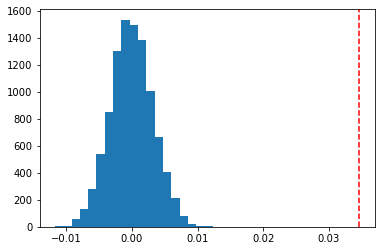

In [62]:
B_vector = df_wide["B"]
diff_B_ratio = np.empty(10000)

for i in range(10000):
    permuted_B_vector = np.random.permutation(B_vector)
    permuted_B_vector_not_homeowner = permuted_B_vector[:44092]
    permuted_B_vector_homeowner = permuted_B_vector[44092:]
 
    diff_B_ratio[i] = np.mean(permuted_B_vector_homeowner) - np.mean(permuted_B_vector_not_homeowner)
    

plt.hist(diff_B_ratio, bins = 20)
plt.axvline(0.0346, c='r', linestyle="--")
plt.show()

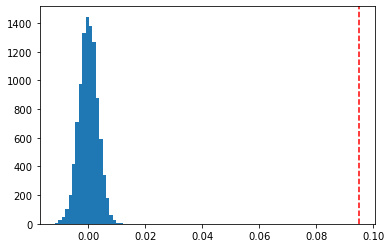

In [63]:
E_vector = df_wide["E"]
diff_E_ratio = np.empty(10000)

for i in range(10000):
    permuted_E_vector = np.random.permutation(E_vector)
    permuted_E_vector_not_homeowner = permuted_E_vector[:44092]
    permuted_E_vector_homeowner = permuted_E_vector[44092:]
 
    diff_E_ratio[i] = np.mean(permuted_E_vector_homeowner) - np.mean(permuted_E_vector_not_homeowner)
    

plt.hist(diff_E_ratio, bins = 20)
plt.axvline(0.0951, c='r', linestyle="--")
plt.show()

For both vectors, the observed difference is completely outside the permuted resampling distribution, so p_value = 0. So it is not in line with null hypothesis.

Now let's check for married_couple.

In [64]:
married_dist = pd.DataFrame(df_wide.groupby("married_couple", dropna=False)["customer_ID"].nunique())
married_dist.columns = ["#Customers"]

vector_b_ratio = pd.DataFrame(df_wide.groupby("married_couple", dropna=False)["B"].mean())
vector_e_ratio = pd.DataFrame(df_wide.groupby("married_couple", dropna=False)["E"].mean())

married_dist = married_dist.merge(vector_b_ratio, on="married_couple")
married_dist = married_dist.merge(vector_e_ratio, on="married_couple")

married_dist

,#Customers,B,E
married_couple,,,
0,76473,0.471722,0.453546
1,20536,0.492355,0.496348


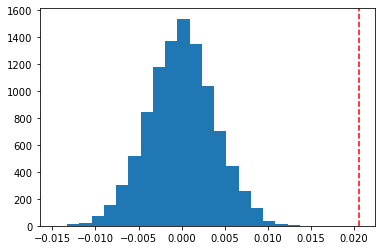

In [65]:
B_vector = df_wide["B"]
diff_B_ratio = np.empty(10000)

for i in range(10000):
    permuted_B_vector = np.random.permutation(B_vector)
    permuted_B_vector_not_married = permuted_B_vector[:76473]
    permuted_B_vector_married = permuted_B_vector[76473:]
 
    diff_B_ratio[i] = np.mean(permuted_B_vector_not_married) - np.mean(permuted_B_vector_married)
    

plt.hist(diff_B_ratio, bins = 20)
plt.axvline(0.0206, c='r', linestyle="--")
plt.show()


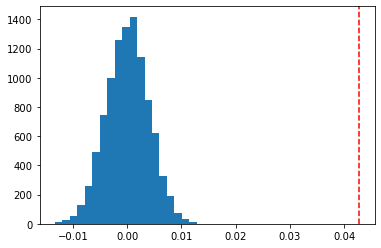

In [66]:
E_vector = df_wide["E"]
diff_E_ratio = np.empty(10000)

for i in range(10000):
    permuted_E_vector = np.random.permutation(E_vector)
    permuted_E_vector_not_married = permuted_E_vector[:76473]
    permuted_E_vector_married = permuted_E_vector[76473:]
 
    diff_E_ratio[i] = np.mean(permuted_E_vector_married) - np.mean(permuted_E_vector_not_married)
    

plt.hist(diff_E_ratio, bins = 20)
plt.axvline(0.0428, c='r', linestyle="--")
plt.show()

In [67]:
df_wide[["homeowner", "married_couple"]].isna().sum()


homeowner         0
married_couple    0
dtype: int64

## 2.6.3 Boolean variables - conclusion<a id='2.6.3_Boolean_variables_conclusion'></a>


For both vectors, the observed difference is completely outside the permuted resampling distribution, so p_value = 0. So it is not in line with null hypothesis.

As such, we will include homeowner and married_couple in model development. There are no missing values for these two variables.



## 2.7 Dealing with Shopping History<a id='2.7_Shopping_History'></a>

  
We now turn our attention to history of Product vectors that is available. 
As we saw in the shopping_pts analysis, customers are more experimentative in the beginning with product vectors and as they take more quotes, they tend to change vectors less and less. For model development, the two choices are:

1) Consider all history available for each customer: With this approach, while more data is available for certain customers, the no. of such customers is not more than 20% (for shopping_pt 7). Also, for each shopping_pt, a different model would be required, given the no. of variables would change. Each model would get to learn from less no. of observations. This might lead to overfitting.

2) Consider the final 2 or 3 available quotes: During the shopping pt analysis we saw that all customers take min. 3 quotes to decide. So for those who decide on the 3rd quote, 2 quotes are available before knowing their final decision. For 94% of the customers 3 or more quotes are available before their final decision. We could build two models - one based on final 2 quotes and another based on final 3. We could then compare their performance to see which one performs better on the test set.







## 2.8 Summary<a id='2.8_Summary'></a>


During the EDA stage, all independent variables were looked at in depth to understand their characteristics and how they seems to interact with the target vectors. A statistical approach was used to test whether differences amongst various classes in each categorical variable are significant or not.

The following are the key outcomes based on the work in this stage:

1) It was deemed appropriate to drop some of the variables from model development. These variables are 'day', 'time', 'risk_factor' and 'location'. These variable either explain very little about the target('day', time'), have very large missing values('risk_factor) or have very high no. of classes and low instances per class ('location').

2) Strategy to impute missing values: For each variable with missing values, an imputation strategy was outlined.

    a) C_previous: Most frequent class (3)
    b) duration_previous: Median
    c) car_value: Median

3) Dealing with numerical variables: As the variables have very different values and spread, they would have to be scaled before fitting the model.

4) Build model based on final 2 and final 3 quotes available: Such models would be able to learn from larger no. of observations and hence learn the generic relationship. We would compare performance between models to decide which one to finally deploy.  


